# Autism Spectrum Disorder (ASD) Prediction

## Objective
Develop a machine learning model to predict whether a person has Autism Spectrum Disorder (ASD) based on screening data.

## Dataset
The dataset can be accessed from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/426/autism+screening+adult).


In [13]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Data

In [14]:
with open("./data/Autism-Adult-Data.arff", mode="r") as f:
    arff_data = arff.load(f)

df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])
print(f"Dataset Shape: {df.shape}")
df.head(3)

Dataset Shape: (704, 21)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES


In [16]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata


# Create metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

# Initialize CTGAN
synthesizer = CTGANSynthesizer(
    metadata,
    epochs=300,
    verbose=True
)

# Train on real data
synthesizer.fit(df)

# Generate synthetic data
synthetic_df = synthesizer.sample(200)

print(synthetic_df.head())

c:\Users\ijona\Desktop\Working\BE-Mini-Project\.venv\Lib\site-packages\sdv\single_table\base.py:168: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

c:\Users\ijona\Desktop\Working\BE-Mini-Project\.venv\Lib\site-packages\sdv\single_table\base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (0.56) | Discrim. (-0.04): 100%|██████████| 300/300 [00:50<00:00,  5.92it/s]


  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0        1        0        0        1        0        0        0        0   
1        1        1        0        1        0        0        1        1   
2        1        0        0        1        0        1        0        1   
3        0        0        0        1        0        0        0        0   
4        1        0        0        0        0        1        0        1   

  A9_Score A10_Score  ...  gender        ethnicity jundice austim  \
0        0         1  ...       f   White-European      no     no   
1        1         1  ...       f            Asian      no     no   
2        0         0  ...       m   White-European      no     no   
3        0         1  ...       m   White-European      no     no   
4        1         1  ...       f  Middle Eastern       no    yes   

   contry_of_res used_app_before result     age_desc relation Class/ASD  
0          India              no    1.0  18 and 

In [21]:
df = pd.concat([df, synthetic_df], axis=0, ignore_index=True)

## 3. Data Cleaning and Exploration

In [22]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         904 non-null    object 
 1   A2_Score         904 non-null    object 
 2   A3_Score         904 non-null    object 
 3   A4_Score         904 non-null    object 
 4   A5_Score         904 non-null    object 
 5   A6_Score         904 non-null    object 
 6   A7_Score         904 non-null    object 
 7   A8_Score         904 non-null    object 
 8   A9_Score         904 non-null    object 
 9   A10_Score        904 non-null    object 
 10  age              902 non-null    float64
 11  gender           904 non-null    object 
 12  ethnicity        777 non-null    object 
 13  jundice          904 non-null    object 
 14  austim           904 non-null    object 
 15  contry_of_res    904 non-null    object 
 16  used_app_before  904 non-null    object 
 17  result          

In [23]:
# 'age' might be read as object/string if there are bad values. Force convert to numeric.
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Check for missing values after conversion
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
A1_Score             0
A2_Score             0
A3_Score             0
A4_Score             0
A5_Score             0
A6_Score             0
A7_Score             0
A8_Score             0
A9_Score             0
A10_Score            0
age                  2
gender               0
ethnicity          127
jundice              0
austim               0
contry_of_res        0
used_app_before      0
result               0
age_desc             0
relation           114
Class/ASD            0
dtype: int64


In [24]:
# Fill missing age with median (robust to outliers)
df['age'] = df['age'].fillna(df['age'].median())

eth_mode = df['ethnicity'].mode()[0]
df['ethnicity'] = df['ethnicity'].fillna(eth_mode)

rel_mode = df['relation'].mode()[0]
df['relation'] = df['relation'].fillna(rel_mode)

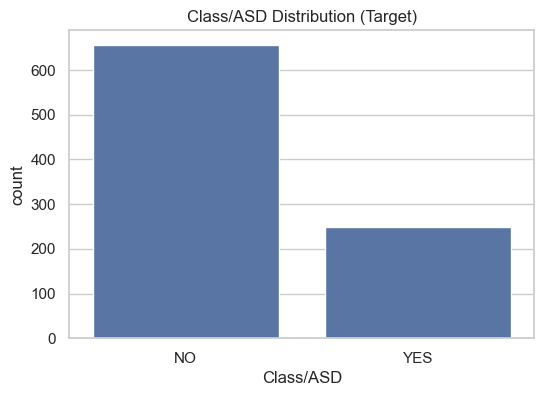

In [25]:
# Visualize Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class/ASD', data=df)
plt.title('Class/ASD Distribution (Target)')
plt.show()

## 4. Feature Engineering & Preprocessing

We need to handle categorical variables and remove columns that might cause data leakage or are irrelevant.

*   **`result`**: This is likely the sum of A1-A10 scores. Including it might dominate the model. We will remove it to let the model learn from the raw answers.
*   **`age_desc`**: Typically contains a single value (e.g., "18 and more"). If so, it's redundant.

In [26]:
# Check unique values in age_desc
print("Unique age_desc:", df['age_desc'].unique())

# Drop 'result' (leakage risk) and 'age_desc' (constant)
df_clean = df.drop(['result', 'age_desc', 'austim', 'used_app_before', 'jundice'], axis=1)

# Convert A1..A10 scores to numeric
score_cols = [f'A{i}_Score' for i in range(1, 11)]
for col in score_cols:
    df_clean[col] = pd.to_numeric(df_clean[col])

df_clean.head()

Unique age_desc: ['18 and more']


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,contry_of_res,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,f,White-European,United States,Self,NO
1,1,1,0,1,0,0,0,1,0,1,24.0,m,Latino,Brazil,Self,NO
2,1,1,0,1,1,0,1,1,1,1,27.0,m,Latino,Spain,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,35.0,f,White-European,United States,Self,NO
4,1,0,0,0,0,0,0,1,0,0,40.0,f,White-European,Egypt,Self,NO


In [27]:
# Encode Target Variable
le = LabelEncoder()
df_clean['Class/ASD'] = le.fit_transform(df_clean['Class/ASD'])
print(f"Target Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# One-Hot Encoding for categorical features
categorical_cols = [
    col for col in ['gender', 'ethnicity', 'jundice', 'contry_of_res', 'used_app_before', 'relation']
    if col in df_clean.columns
]
df_encoded = pd.get_dummies(
    df_clean,
    columns=categorical_cols,
    drop_first=True
)

print(f"Encoded Dataset Shape: {df_encoded.shape}")

Target Mapping: {'NO': np.int64(0), 'YES': np.int64(1)}
Encoded Dataset Shape: (904, 93)


## 5. Model Training

In [29]:
# Define Features (X) and Target (y)
X = df_encoded.drop('Class/ASD', axis=1)
y = df_encoded['Class/ASD']

# Train-Test Split (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [30]:
# Compute class imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost with class weighting
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

## 6. Model Evaluation

In [31]:
# Predictions
y_pred = xgb_model.predict(X_test)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_probs))

Accuracy: 0.8495575221238938

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       164
           1       0.69      0.82      0.75        62

    accuracy                           0.85       226
   macro avg       0.81      0.84      0.82       226
weighted avg       0.86      0.85      0.85       226


ROC-AUC Score: 0.9424665617623919


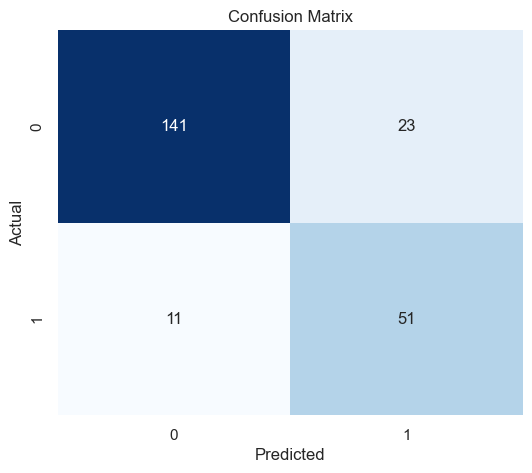

In [32]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

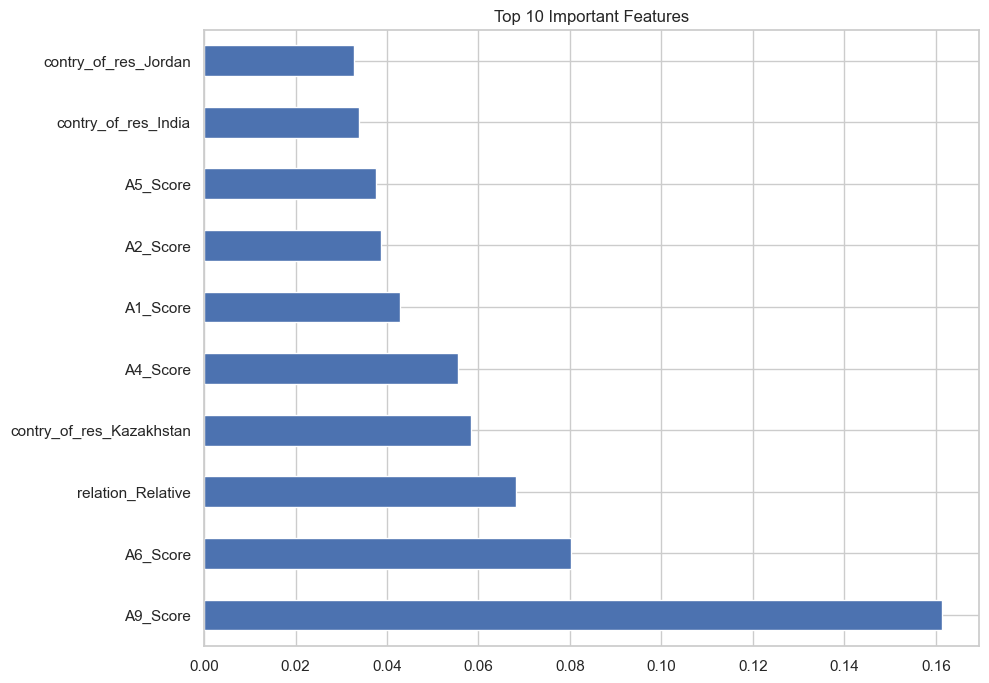

In [33]:
# Feature Importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 8))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

## Test with a Sample

Let's create a sample data point (similar to a row in the dataset) and predict if the person has ASD.

In [37]:
TEST = [
    {
    'A1_Score': 1, 'A2_Score': 1, 'A3_Score': 1, 'A4_Score': 1, 'A5_Score': 1,
    'A6_Score': 1, 'A7_Score': 1, 'A8_Score': 1, 'A9_Score': 1, 'A10_Score': 1,
    'age': 18.0,
    'gender': 'm',
    'ethnicity': 'Asian',
    'contry_of_res': 'India',
    'relation': 'Self'
},
{
    'A1_Score': 1, 'A2_Score': 1, 'A3_Score': 1, 'A4_Score': 1, 'A5_Score': 0,
    'A6_Score': 0, 'A7_Score': 1, 'A8_Score': 1, 'A9_Score': 0, 'A10_Score': 0,
    'age': 26.0,
    'gender': 'f',
    'ethnicity': 'White-European',
    'contry_of_res': 'United States',
    'relation': 'Self'
},
{
        'A1_Score': 0, 'A2_Score': 1, 'A3_Score': 1, 'A4_Score': 0, 'A5_Score': 1,
        'A6_Score': 1, 'A7_Score': 0, 'A8_Score': 1, 'A9_Score': 1, 'A10_Score': 1,
        'age': 22.0,
        'gender': 'm',
        'ethnicity': 'Hispanic',
        'contry_of_res': 'Mexico',
        'relation': 'Self',
        # Expected output: YES (likely ASD) → most scores are 1, several key symptoms present
    },
    {
        'A1_Score': 1, 'A2_Score': 0, 'A3_Score': 1, 'A4_Score': 1, 'A5_Score': 0,
        'A6_Score': 1, 'A7_Score': 1, 'A8_Score': 0, 'A9_Score': 1, 'A10_Score': 0,
        'age': 30.0,
        'gender': 'f',
        'ethnicity': 'Black',
        'contry_of_res': 'Canada',
        'relation': 'Parent',
        # Expected output: YES (possible ASD) → mixed scores, but key symptom scores (A1, A3, A4, A6, A7, A9) indicate moderate risk
    },
    {
        'A1_Score': 0, 'A2_Score': 0, 'A3_Score': 0, 'A4_Score': 0, 'A5_Score': 0,
        'A6_Score': 0, 'A7_Score': 0, 'A8_Score': 0, 'A9_Score': 0, 'A10_Score': 0,
        'age': 25.0,
        'gender': 'f',
        'ethnicity': 'White-European',
        'contry_of_res': 'United Kingdom',
        'relation': 'Self',
        # Expected output: NO → all scores are 0, very low risk
    },
    {
        'A1_Score': 0, 'A2_Score': 1, 'A3_Score': 0, 'A4_Score': 0, 'A5_Score': 0,
        'A6_Score': 0, 'A7_Score': 0, 'A8_Score': 0, 'A9_Score': 0, 'A10_Score': 0,
        'age': 28.0,
        'gender': 'm',
        'ethnicity': 'Asian',
        'contry_of_res': 'India',
        'relation': 'Parent',
        # Expected output: NO → single 1 in a non-critical question, majority scores indicate low risk
    }, 
]


In [38]:


def get_pred(data:dict):
    # Convert to DataFrame
    sample_df = pd.DataFrame([data])

    # Apply One-Hot Encoding (same logic as training)
    sample_encoded = pd.get_dummies(sample_df, columns=categorical_cols)

    # Align columns: Ensure sample has same columns as training data X
    # Add missing columns with 0, drop extra columns if any
    sample_encoded = sample_encoded.reindex(columns=X.columns, fill_value=0)

    # Predict
    pred_idx = xgb_model.predict(sample_encoded)[0]
    pred_label = le.inverse_transform([pred_idx])[0]
    asd_probability = xgb_model.predict_proba(sample_encoded)[0][1]
    print("="*50, end="\n")
    print("Sample Data:")
    print(sample_df.iloc[0])
    print("-" * 30)
    print(f"Prediction: {pred_label}")
    print(f"ASD Probability: {asd_probability:.2f}")
    print("="*50, end="\n\n")

In [39]:
for data in TEST:
    get_pred(data)

Sample Data:
A1_Score             1
A2_Score             1
A3_Score             1
A4_Score             1
A5_Score             1
A6_Score             1
A7_Score             1
A8_Score             1
A9_Score             1
A10_Score            1
age               18.0
gender               m
ethnicity        Asian
contry_of_res    India
relation          Self
Name: 0, dtype: object
------------------------------
Prediction: YES
ASD Probability: 1.00

Sample Data:
A1_Score                      1
A2_Score                      1
A3_Score                      1
A4_Score                      1
A5_Score                      0
A6_Score                      0
A7_Score                      1
A8_Score                      1
A9_Score                      0
A10_Score                     0
age                        26.0
gender                        f
ethnicity        White-European
contry_of_res     United States
relation                   Self
Name: 0, dtype: object
------------------------------
Pr

In [40]:
import joblib
joblib.dump(xgb_model, "asd_model.pkl")

['asd_model.pkl']

## Conclusion
The XGBoost model has been trained and evaluated. The feature importance plot gives insights into which factors (e.g., specific screening questions A1-A10, or demographics) contribute most to the prediction.

predicts Class/ASD using features like:

A1–A10 questionnaire scores

Age

Gender, ethnicity, country, relation